In [1]:
#!pip install pycaret[full]
#!pip install explainerdashboard
#!pip install --upgrade fairlearn==0.7.0 raiwidgets
#!pip install scikit-learn==0.23.2

# Data Import

## Import Modules

In [11]:
import os
from pathlib import Path
from re import search
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.classification import setup, compare_models, create_model, tune_model, evaluate_model, load_model, plot_model, add_metric, dashboard, check_fairness
from utils import  adapt_datatype

## Set Paths

In [3]:
# set paths
ROOTDIR = os.getcwd()
DATAPATH = os.path.join(ROOTDIR, "data")
MODELPATH = os.path.join(ROOTDIR, "model")
Path(DATAPATH).mkdir(parents=True, exist_ok=True)
Path(MODELPATH).mkdir(parents=True, exist_ok=True)

## Import Customer Churn Dataset

In [4]:
# import data
filename = 'telco_customer_churn.csv'
df = pd.read_csv(os.path.join(DATAPATH, filename))
# adapt data types
df = adapt_datatype(df)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Setup the Auto-ML Experiment

In [5]:
# pycaret does all the data prep
setup(df, 
    target='Churn', 
    ignore_features=['customerID'],
    data_split_stratify=True,
    train_size=0.6,
    fold=5,
    log_experiment=True,
    experiment_name='churn_prediction',
    session_id = 123,
    silent=True)

,Description,Value
0,session_id,123
1,Target,Churn
2,Target Type,Binary
3,Label Encoded,"No: 0, Yes: 1"
4,Original Data,"(7043, 21)"
5,Missing Values,True
6,Numeric Features,3
7,Categorical Features,16
8,Ordinal Features,False
9,High Cardinality Features,False


(None,
 True,
       tenure  MonthlyCharges  TotalCharges  gender_Female  SeniorCitizen_1  \
 0        1.0       29.850000     29.850000            1.0              0.0   
 1       34.0       56.950001   1889.500000            0.0              0.0   
 2        2.0       53.849998    108.150002            0.0              0.0   
 3       45.0       42.299999   1840.750000            0.0              0.0   
 4        2.0       70.699997    151.649994            1.0              0.0   
 ...      ...             ...           ...            ...              ...   
 7038    24.0       84.800003   1990.500000            0.0              0.0   
 7039    72.0      103.199997   7362.899902            1.0              0.0   
 7040    11.0       29.600000    346.450012            1.0              0.0   
 7041     4.0       74.400002    306.600006            0.0              1.0   
 7042    66.0      105.650002   6844.500000            0.0              0.0   
 
       Partner_No  Dependents_Yes  P

## Load Trained Model Pipeline

In [9]:
# load model
pipeline = load_model(os.path.join(MODELPATH, 'churn_model_pipeline'))
pipeline

Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False,
                                      features_todrop=['customerID'],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='Churn',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                n...
                ('dummy', Dummify(target='Churn')),
                ('fix_perfect', Remove_100(target='Churn')),
                ('clean_names', Clean_Colum_Names()),
                ('feature_select', 'passthrough'), ('fix_multi', 'passthrough'),
 

# Model Fairness 

In [10]:
model = pipeline['trained_model']
model

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage='auto',
                           solver='lsqr', store_covariance=False, tol=0.0001)

,Samples,Accuracy,AUC,Recall,Precision,F1,Kappa,MCC,Selection Rate
gender,,,,,,,,,
Female,1397,0.788117,0.711144,0.545455,0.618182,0.579545,0.438657,0.440192,0.23622
Male,1421,0.803659,0.730127,0.574866,0.641791,0.606488,0.476213,0.477495,0.235749


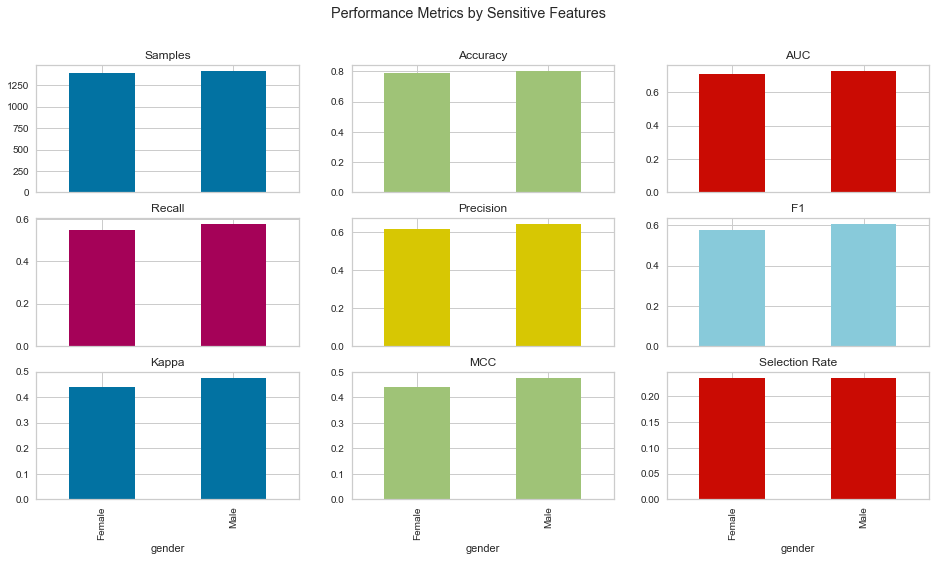

In [14]:
check_fairness(model, sensitive_features='gender')

In [ ]:
# as we can see, no obvious model unfairness can be detected based on gender